In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps
# list(colormaps)

In [36]:
data_ml = pd.read_csv('data_ml.csv')

In [9]:
data_ml.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        7043 non-null   int64  
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   object 
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


## Feature Engineering

### Overview

In [34]:
#Checking levels of categorical features
for i in data_ml.columns:
    if data_ml[i].dtype == 'object':
        print(f'{i} {data_ml[i].unique()}')

gender ['Female' 'Male']
SeniorCitizen ['No' 'Yes']
Partner ['Yes' 'No']
Dependents ['No' 'Yes']
PhoneService ['No' 'Yes']
MultipleLines ['No phone service' 'No' 'Yes']
InternetService ['DSL' 'Fiber optic' 'No']
OnlineSecurity ['No' 'Yes' 'No internet service']
OnlineBackup ['Yes' 'No' 'No internet service']
DeviceProtection ['No' 'Yes' 'No internet service']
TechSupport ['No' 'Yes' 'No internet service']
StreamingTV ['No' 'Yes' 'No internet service']
StreamingMovies ['No' 'Yes' 'No internet service']
Contract ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn ['No' 'Yes']


### Binning

In [16]:
''' 
Binning of the feature 'tenure' due to the multimodal nature of the data. Goal was to keep the original distribution.
The distribution of tenure must be monitored after 6 years 

'''

" \nBinning of the feature 'tenure' due to the multimodal nature of the data. Goal was to keep the original distribution.\nBinning must be monitored how the distribution behaves after 6 years.\n\n"

Text(0.5, 1.0, 'Distribution of feature tenure')

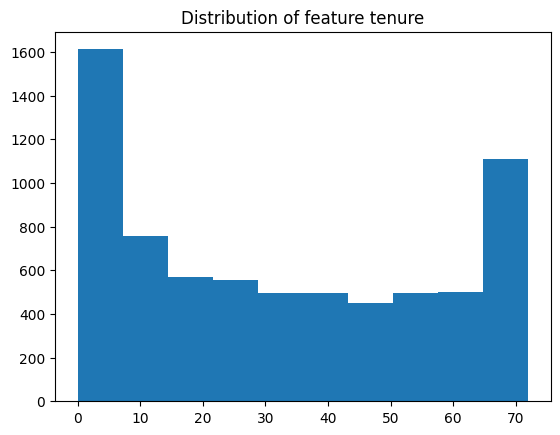

In [47]:
#Plotting distribution of tenure
plt.hist(data_ml.tenure)
plt.title('Distribution of feature tenure')

In [30]:
#Binning feature tenure in 6 parts
data_ml['tenure_class'] = pd.cut(x=data_ml.tenure, bins=6, labels=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'])

Text(0.5, 1.0, 'tenure distribution with binning')

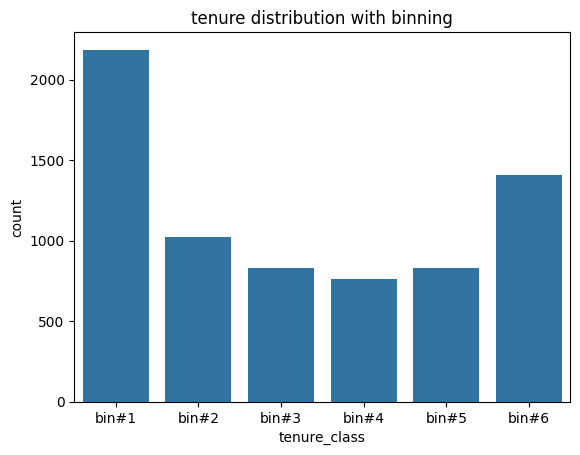

In [31]:
#Plotting tenure with binning
sns.countplot(x=data_ml.tenure_class,order=['bin#1','bin#2','bin#3','bin#4','bin#5','bin#6'])
plt.title('tenure distribution with binning')

In [33]:
#Droping original feature tenure
data_ml = data_ml.drop(columns='tenure')

### Train Test Split

In [18]:
from sklearn.model_selection import train_test_split

X = data_ml.drop('Churn',axis=1)
y = data_ml['Churn']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=123)

### Quantile Transformer

In [19]:
''' 
Quantile transformation of the features 'MonthlyCharges' and 'Total Charges'
.fit_transform of X_train and .transform of X_test to avoid data leakage

'''

from sklearn.preprocessing import QuantileTransformer

quantile_normal = QuantileTransformer(output_distribution='normal')

# Fit Transform X_train
X_train[['MonthlyCharges','TotalCharges']] = quantile_normal.fit_transform(X_train[['MonthlyCharges','TotalCharges']])

#Transform X_test
X_test[['MonthlyCharges','TotalCharges']] = quantile_normal.transform(X_test[['MonthlyCharges','TotalCharges']])

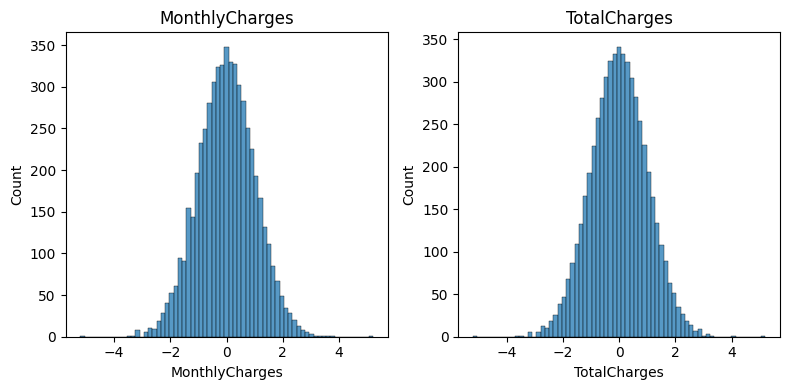

In [20]:
#Plot transformed features
plt.figure(figsize=(8, 4))

# Subplot 1
plt.subplot(1, 2, 1)
sns.histplot(X_train.MonthlyCharges)
plt.title('MonthlyCharges')

# Subplot 2
plt.subplot(1, 2, 2)
sns.histplot(X_train.TotalCharges)
plt.title('TotalCharges')

plt.tight_layout()
plt.show()


### One Hot Encoding

In [21]:
ohe_features_train = X_train.drop(['MonthlyCharges','TotalCharges'],axis=1)
X_train = X_train.drop(ohe_features_train,axis=1)
ohe = pd.get_dummies(ohe_features_train,drop_first=True)
X_train = X_train.join(ohe)


ohe_features_test = X_test.drop(['MonthlyCharges','TotalCharges'],axis=1)
X_test = X_test.drop(ohe_features_test,axis=1)
ohe = pd.get_dummies(ohe_features_test,drop_first=True)
X_test = X_test.join(ohe)

### Feature Selection

In [22]:
from sklearn.feature_selection import mutual_info_classif

#Copy Train Test Split
X_train_select, X_test_select, y_train_select, y_test_select = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

#Mutual Info Classifier
mutual_info = mutual_info_classif(X_train_select,y_train_select,discrete_features='auto',random_state=123)

# Dataframe
mutual_info_df = pd.DataFrame({'Features':X_train.columns,'Mutual_Info':mutual_info})

#10 largest features
mutual_info_df.nlargest(20,columns='Mutual_Info').sort_values(by='Mutual_Info',ascending=False)

,Features,Mutual_Info
24,Contract_Two year,0.063533
9,InternetService_Fiber optic,0.054378
1,TotalCharges,0.049123
31,tenure_class_newbie,0.046891
13,OnlineBackup_No internet service,0.042430
0,MonthlyCharges,0.040286
17,TechSupport_No internet service,0.033817
19,StreamingTV_No internet service,0.033071
15,DeviceProtection_No internet service,0.031919
27,PaymentMethod_Electronic check,0.031236


### Class Balancing

In [23]:
#Original Distribution of the target 'Churn'
y_train.value_counts(normalize=True)

Churn
No     0.734222
Yes    0.265778
Name: proportion, dtype: float64

In [24]:
from imblearn.over_sampling import SMOTE

#Balancing of the target 'Churn'
X_bal, y_bal = SMOTE().fit_resample(X_train,y_train)

In [25]:
#Distribution after balancing
y_bal.value_counts()

Churn
Yes    4130
No     4130
Name: count, dtype: int64

# Machine Learning

In [26]:
from sklearn import metrics
from sklearn.model_selection import GridSearchCV

# Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

#Fit Model
lr.fit(X_bal,y_bal)

#Predict
y_pred_lr = lr.predict(X_test)

#Create empty dict
metrics_lr = {}

#Metrics to dict
metrics_lr['Accuracy'] = metrics.accuracy_score(y_test,y_pred_lr)
metrics_lr['Recall'] =metrics.recall_score(y_test,y_pred_lr,pos_label='Yes')
metrics_lr['Precision'] =metrics.precision_score(y_test,y_pred_lr,pos_label='Yes')
# metrics_lr['F1'] = metrics.f1_score(y_test,y_pred_lr,pos_label='Yes')

metrics_lr

{'Accuracy': 0.7796730632551528,
 'Recall': 0.767379679144385,
 'Precision': 0.5627450980392157}

In [28]:
#Check for overfitting
y_pred_lr_train = lr.predict(X_train)

metrics.accuracy_score(y_train,y_pred_lr_train)

0.7692444444444444

In [29]:
#Confusion Matrix
metrics.confusion_matrix(y_test,y_pred_lr).round(2)

array([[810, 223],
       [ 87, 287]], dtype=int64)

In [30]:
#set range for hyperparameter c
c_range = np.logspace(-4,4,10)

#creat dict for c
c_dict = {"C":c_range}

#instantiate class GridSearchCV
clf_lr = GridSearchCV(lr,param_grid=c_dict,cv=5,scoring="accuracy")

#fit model
clf_lr.fit(X_bal,y_bal)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-04, 7.74263683e-04, 5.99484250e-03, 4.64158883e-02,
       3.59381366e-01, 2.78255940e+00, 2.15443469e+01, 1.66810054e+02,
       1.29154967e+03, 1.00000000e+04])},
             scoring='accuracy')

# K Nearest Neighborhood

In [31]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()

#Fit Model
knn.fit(X_bal,y_bal)

#Predict
y_pred_knn = knn.predict(X_test)

#Create empty dict
metrics_knn = {}

#Metrics to dict
metrics_knn['Accuracy'] = metrics.accuracy_score(y_test,y_pred_knn)
metrics_knn['Recall'] =metrics.recall_score(y_test,y_pred_knn,pos_label='Yes')
metrics_knn['Precision'] =metrics.precision_score(y_test,y_pred_knn,pos_label='Yes')
# metrics_knn['F1'] = metrics.f1_score(y_test,y_pred_knn,pos_label='Yes')

metrics_knn

{'Accuracy': 0.7157071783937455,
 'Recall': 0.6978609625668449,
 'Precision': 0.4762773722627737}

In [32]:
#Check for overfitting
y_pred_knn_train = knn.predict(X_train)

metrics.accuracy_score(y_train,y_pred_knn_train)

0.8344888888888888

In [33]:
#Confusion Matrix
metrics.confusion_matrix(y_test,y_pred_knn).round(2)

array([[746, 287],
       [113, 261]], dtype=int64)

In [34]:
#KNN Classifier
knn = KNeighborsClassifier()

#Param Range Heuristic n_neighbors
n_neighbor_heuristic = int(len(X_train)**0.5)

#Dict Param Range
knn_dict = {'n_neighbors': range(n_neighbor_heuristic-10,n_neighbor_heuristic+10)}

#GridSearchCV
clf = GridSearchCV(knn,param_grid=knn_dict,cv=5,scoring='accuracy')

#Fit Model with balanced data
clf.fit(X_bal,y_bal)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(65, 85)}, scoring='accuracy')

Text(0, 0.5, 'mean_test_score')

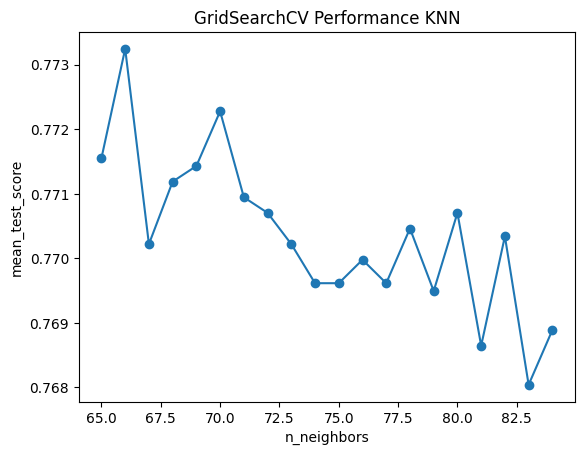

In [35]:
plt.plot(clf.cv_results_['param_n_neighbors'],clf.cv_results_['mean_test_score'],marker='o')
plt.title('GridSearchCV Performance KNN')
plt.xlabel('n_neighbors')
plt.ylabel('mean_test_score')

In [36]:
clf.best_params_

{'n_neighbors': 66}

# Random Forest

In [37]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=123,n_estimators=100)

rf.fit(X_bal,y_bal)

y_pred_rf = rf.predict(X_test)

In [38]:
metrics_rf = {}

metrics_rf['Accuracy'] = metrics.accuracy_score(y_test,y_pred_rf)
metrics_rf['Recall'] = metrics.recall_score(y_test,y_pred_rf,pos_label='Yes')
metrics_rf['Precision'] = metrics.precision_score(y_test,y_pred_rf,pos_label='Yes')
# metrics_rf['F1'] = metrics.precision_score(y_test,y_pred_rf,pos_label='Yes')

metrics_rf

{'Accuracy': 0.7739872068230277,
 'Recall': 0.6336898395721925,
 'Precision': 0.5669856459330144}

In [39]:
#Check for overfitting
y_pred_rf_train = rf.predict(X_train)

metrics.accuracy_score(y_train,y_pred_rf_train)

0.9976888888888888

In [40]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,y_pred_rf,normalize='all').round(2)

array([[0.61, 0.13],
       [0.1 , 0.17]])

In [41]:

rf_dict = {'n_estimators':range(1,51), 'max_depth':range(1,30)}

clf = GridSearchCV(rf,param_grid=rf_dict,scoring='accuracy',cv=5,verbose=2,n_jobs=-1)

clf.fit(X_bal,y_bal)

Fitting 5 folds for each of 1450 candidates, totalling 7250 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=123),
             n_jobs=-1,
             param_grid={'max_depth': range(1, 30),
                         'n_estimators': range(1, 51)},
             scoring='accuracy', verbose=2)

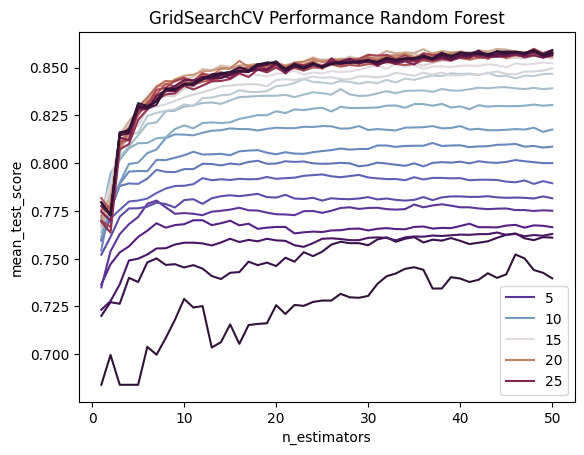

In [42]:
sns.lineplot(x=clf.cv_results_['param_n_estimators'], y=clf.cv_results_['mean_test_score'], 
             hue=clf.cv_results_['param_max_depth'],palette='twilight_shifted')
plt.title('GridSearchCV Performance Random Forest')
plt.xlabel('n_estimators')
plt.ylabel('mean_test_score')
plt.show()

In [43]:
clf.best_params_

{'max_depth': 23, 'n_estimators': 48}

In [44]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results_best = cv_results[cv_results['rank_test_score'] == 1]

mean_test_score_best = np.round([cv_results_best['split0_test_score'].values[0],
                        cv_results_best['split1_test_score'].values[0],
                        cv_results_best['split2_test_score'].values[0],
                        cv_results_best['split3_test_score'].values[0],
                        cv_results_best['split4_test_score'].values[0]],2)

mean_test_score_best

array([0.82, 0.84, 0.87, 0.88, 0.88])

In [45]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=123)

tree.fit(X_bal,y_bal)

y_pred_tree = tree.predict(X_test)

metrics.accuracy_score(y_test,y_pred_tree)

0.7043354655294953

In [46]:
#Check for overfitting
y_pred_tree_train = tree.predict(X_train)
metrics.accuracy_score(y_train,y_pred_tree_train)

0.9976888888888888

# Support Vector Machine

In [70]:
from sklearn import svm

svc = svm.SVC(kernel='rbf')

svc.fit(X_bal,y_bal)

y_pred_svc = svc.predict(X_test)

metrics.accuracy_score(y_test,y_pred_svc)

0.757640369580668